# 1D simulations

3 methods for the 1 dimensional simulation:
1. Forward Euler method
2. Next Reaction Method
3. Runge-Kutta 4

The root is organizes as follows:
4 columella cells followed by 1 QC and 5 vascular cells. 
- PIN distribution of the cell types:
- Columella: has PIN on both left and right cell wall;
QC AND Vascular: have PINs only on left side (transporting auxin downwards, towards root tip).

Root tip will be on the left of the plots, root top on the right

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
%matplotlib notebook
import cv2
import re
import glob

### Forward Euler

Update function (will also be used for the NRM)

In [4]:
def update_n_cells(cells, pins, D=0.3, T=0.2):
    d_cells = np.zeros(cells.shape)
    for i in range(len(cells)):
        if i == 0:
            # extreme left
            d_cells[i] = D*(cells[1] - cells[0]) + T*(pins[i+1,0]*cells[1] - (pins[i,0]*cells[0] + pins[i,1]*cells[0]))
        elif i == len(cells)-1:
            # extreme right
            d_cells[i] =  D*(cells[-2] - cells[-1]) + T*(pins[-2,1]*cells[-2] - (pins[-1,0]*cells[-1] + pins[-1,1]*cells[-1]))
        else:
            # all other cells
            d_cells[i] = D*(cells[i-1] -2*cells[i] + cells[i+1]) +T*(pins[i-1,1]*cells[i-1] 
                                                                     - (pins[i,0]*cells[i]+pins[i,1]*cells[i]) 
                                                                     + pins[i+1,0]*cells[i+1])
    return d_cells

<IPython.core.display.Javascript object>


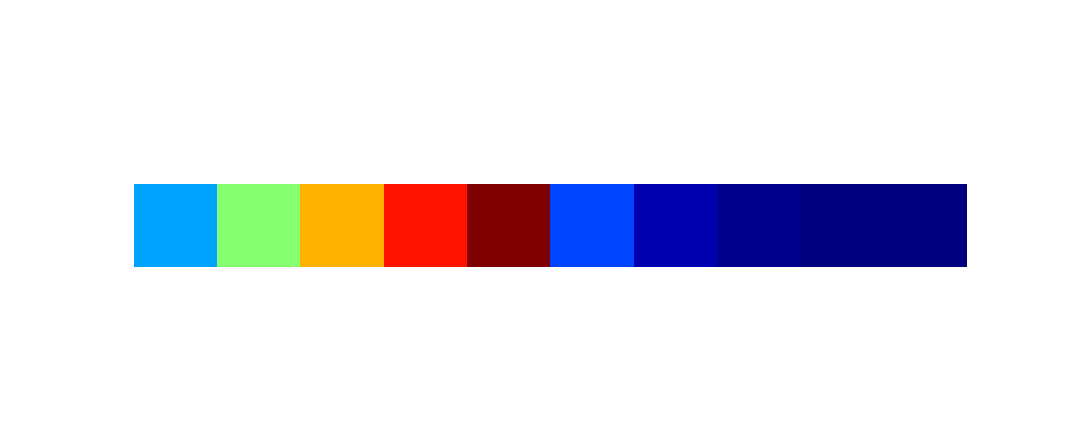

In [6]:
%matplotlib notebook

cells=np.ones((10,1))
cells[-1]=cells[-1]*100

pins=np.array([[8,8,8,8,8,8,8,8,8,8],
               [8,8,8,8,0,0,0,0,0,0]])

fig=plt.figure(figsize=(12,5)) 
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells.T, cmap="jet")

timeline = []
dt=0.1
for t in np.arange(0,20,dt):
    cells_step = dt*update_n_cells(cells,pins.T)
    cells = np.add(cells, cells_step)
    timeline.append(cells)
    
    plt.imshow(cells.T, cmap="jet")
    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.legend(["cell1", "cell2", "cell3","cell4","cell5","cell6"])
    
    plt.savefig(f"root_1D_FE/1D_root:{str(t)}.png")
    
# create video of all images
img_test = cv2.imread("root_1D_FE/1D_root:0.0.png")
height , width , layers =  img_test.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('root_1D_FE/1D_FE.avi',fourcc, 20.0, (width, height))

for t in np.arange(0,20,0.1):
    img = cv2.imread(f"root_1D_FE/1D_root:{str(t)}.png")
    out.write(img)
    
cv2.destroyAllWindows()
out.release()

### Next Reaction Method

<IPython.core.display.Javascript object>


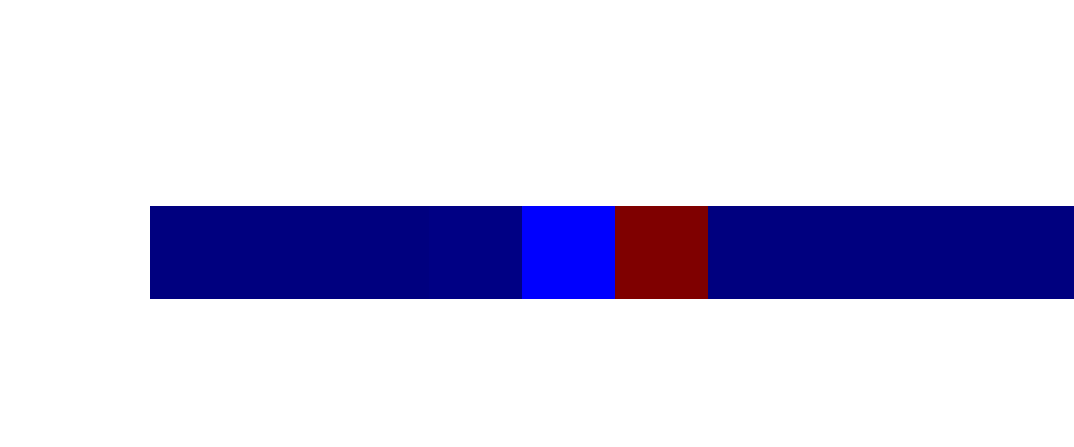

KeyboardInterrupt: 

In [25]:
%matplotlib notebook

cells=np.ones((10,1))
cells[-1]=cells[-1]*100

pins=np.array([[8,8,8,8,8,8,8,8,8,8],
               [8,8,8,8,0,0,0,0,0,0]])

fig=plt.figure(figsize=(12,5)) 
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells.T, cmap="jet")

T = []
t = 0
sim_time=0.25
cells_out=cells
while t<sim_time:
    cells_prev = cells_out    #need to keep track of the previous state
    cells_step = update_n_cells(cells_out, pins.T, D=0.02, T=0.03)
    cells_out = np.add(cells_out, cells_step)
    
    z1 = np.random.uniform(0,1)
    acum = np.cumsum(cells_out)
    atot = acum[-1] 
    tau = -np.log(z1)/np.sum(cells_out)
    z2 = np.random.uniform(0,1)
    zatot = z2*atot
    mu = np.where(acum>zatot)[0][0]
    cells_prev[mu] = cells_prev[mu] + cells_out[mu]    #only one cell will be updated
    cells_out=cells_prev
    t = t + tau
    T.append(t)
    
    plt.imshow(cells_out.T, cmap="jet")
    plt.title(f"Timestep: {str(T[-1])}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    plt.savefig(f"root_1D_NRM/1D_root:{str(T[-1])}.png")
    

In [28]:
# create video of all images
# first, need to sort the images in the correct way
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]


img_test = cv2.imread(f"root_1D_NRM/1D_root:{str(T[-1])}.png")
height , width , layers =  img_test.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('root_1D_NRM/1D_NRM.avi',fourcc, 20.0, (width, height))

images=glob.glob("root_1D_NRM/*.png")
images.sort(key=natural_keys)

for image in images:
    img = cv2.imread(image)
    out.write(img)
    
cv2.destroyAllWindows()
out.release()

### Runge-Kutta 4

In [20]:
# Modified version of the update function
def update_n_cells_rk(t,cells, pins, D=0.3, T=0.2):
    d_cells = np.zeros(cells.shape)
    for i in range(len(cells)):
        if i == 0:
            # extreme left
            d_cells[i] = D*(cells[1] - cells[0]) + T*(pins[i+1,0]*cells[1] - (pins[i,0]*cells[0] + pins[i,1]*cells[0]))
        elif i == len(cells)-1:
            # extreme right
            d_cells[i] =  D*(cells[-2] - cells[-1]) + T*(pins[-2,1]*cells[-2] - (pins[-1,0]*cells[-1] + pins[-1,1]*cells[-1]))
        else:
            # all other cells
            d_cells[i] = D*(cells[i-1] -2*cells[i] + cells[i+1]) +T*(pins[i-1,1]*cells[i-1] 
                                                                     - (pins[i,0]*cells[i]+pins[i,1]*cells[i]) 
                                                                     + pins[i+1,0]*cells[i+1])
    return d_cells


# Actual RK
def RK4(f):
    return lambda t, y, dt: (
            lambda dy1: (
            lambda dy2: (
            lambda dy3: (
            lambda dy4: (dy1 + 2*dy2 + 2*dy3 + dy4)/6
            )( dt * f( t + dt  , y + dy3, pins.T   ) )
        )( dt * f( t + dt/2, y + dy2/2, pins.T ) )
        )( dt * f( t + dt/2, y + dy1/2, pins.T ) )
        )( dt * f( t       , y         ,pins.T) )

<IPython.core.display.Javascript object>


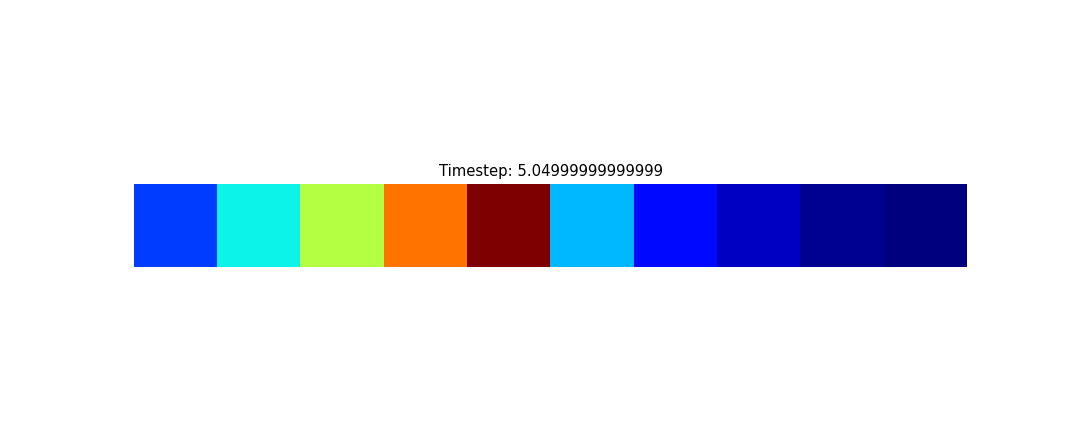

In [21]:
%matplotlib notebook

cells=np.ones((10,1))
cells[-1]=cells[-1]*100

pins=np.array([[8,8,8,8,8,8,8,8,8,8],
               [8,8,8,8,0,0,0,0,0,0]])


fig=plt.figure(figsize=(12,5)) 
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells.T, cmap="jet")

cells=np.ones(10)
cells[-1]=cells[-1]*100
t, y, dt = 0., cells.T, .05

dy = RK4(update_n_cells_rk)


while t <= 5:
    if abs(round(t) - t) < 1:
        t, y = t + dt, y + dy( t, y, dt )
        
        y.shape=(10,1)
        plt.imshow(y.T, cmap="jet")
        plt.title(f"Timestep: {str(t)}")
        plt.axis('off')
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        #print(y)
        plt.savefig(f"root_1D_RK/1D_root:{str(t)}.png")

In [22]:
#To make the video

#First, need to sort the images in the correct way
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]


img_test = cv2.imread(f"root_1D_RK/1D_root:{str(t)}.png")
height , width , layers =  img_test.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('root_1D_RK/1D_RK.avi',fourcc, 20.0, (width, height))

images=glob.glob("root_1D_RK/*.png")
images.sort(key=natural_keys)
for image in images:
    img = cv2.imread(image)
    out.write(img)
    
cv2.destroyAllWindows()
out.release()